# Segmenting and Clustering Neighborhoods in the city of Toronto, Canada

In [202]:
# import all required libraries
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from bs4 import BeautifulSoup
import geocoder
import random

%matplotlib inline

## Start of Part 1

In [203]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [204]:
# Calling Beautiful soup to parse wikipedia html page
soup = BeautifulSoup(page.content, 'html.parser')

In [205]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XrRNuQpAMMEAAQQmG@gAAABX","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":955414546,"wgRevisionId":955414546,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Communications in Ontario","Postal codes in Canada","Toronto","Ontario

In [206]:
# Finding the table with Toronto Neighborhood infomation from wikipedia
toronto_table = soup.find('table', class_ = 'wikitable sortable')

## Reading table from Wikipedia and Create Pandas Dataframe

In [207]:
# Loop through the rows to read tables
# First let's create 3 empty list to contain values for PostalCode, Borough and Neighborhood

table_dict = {'PostalCode': [], 'Borough': [], 'Neighborhood': []}
pcode= []
borough = []
neighborhood = []
for row in toronto_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) > 0:
        table_dict['PostalCode'].append(cells[0].find(text=True).replace('\n', ''))
        table_dict['Borough'].append(cells[1].find(text=True).replace('\n', ''))
        table_dict['Neighborhood'].append(cells[2].find(text=True).replace('\n', ''))
    

In [208]:
# Creating a pandas dataframe using table_dict for Toronto Neighborhood data
toronto_data = pd.DataFrame(table_dict)

In [209]:
# Drop Borough without assigned name
toronto_data = toronto_data[toronto_data['Borough'] != 'Not assigned'].reset_index(drop=True)

In [210]:
# Replace an empty Neighborhood by name of Borough
toronto_data['Neighborhood'] = np.select([toronto_data['Neighborhood'].isin(['', 'Not assigned'])], [toronto_data['Borough']], 
                                        toronto_data['Neighborhood'])

In [211]:
toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Printing out total number of rows in dataframe

In [212]:
print(toronto_data.shape[0])

103


## End of Part 1
## Start of Part 2

## Using CSV file to get latitude and longitude
#### Unable to get coordinates using geocoder

In [213]:
# Read 
lat_long = pd.read_csv('Geospatial_Coordinates.csv')
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [214]:
lat_long.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
lat_long.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [215]:
toronto_data = toronto_data.merge(lat_long, on='PostalCode', how='inner')
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## End of Part 2
## Start of Part 3

## Define FourSquare Credentials

In [216]:
CLIENT_ID = 'K2KJC5IP2ZFNPEX2FBGP4J5XLGD0WRGXSPNFV0DZ0F5AF2QH' # your Foursquare ID
CLIENT_SECRET = 'T41BPP5N5D1V3IXVG43V3W13EPDHHUBYOBREVLBSSTGSNCTD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K2KJC5IP2ZFNPEX2FBGP4J5XLGD0WRGXSPNFV0DZ0F5AF2QH
CLIENT_SECRET:T41BPP5N5D1V3IXVG43V3W13EPDHHUBYOBREVLBSSTGSNCTD


## Explore Neighborhoods in Toronto

In [217]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''Function to get venues around neighborhood'''
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # Make the get reguest
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Returning only relevant information for each nearby venue for analysis
        venues_list.append([[name, lat, lng, v['venue']['categories'][0]['name']] for v in results])
        
    venues_info = pd.DataFrame([row for venue_list in venues_list for row in venue_list],
                              columns=['Neighborhood', 'Latitude', 'Longitude', 'Category'])
    
    return venues_info

In [218]:
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])

In [219]:
toronto_venues.head()

,Neighborhood,Latitude,Longitude,Category
0,Parkwoods,43.753259,-79.329656,Park
1,Parkwoods,43.753259,-79.329656,Bus Stop
2,Parkwoods,43.753259,-79.329656,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,Construction & Landscaping
4,Victoria Village,43.725882,-79.315572,Hockey Arena


In [220]:
# Ond Hot Encoder on Category
cat_encode = pd.get_dummies(toronto_venues['Category'])

# New DataFrame with Neighborhood, Latitude, Longitude and cat_encode
toronto_cat = pd.concat([toronto_venues.drop(columns=['Category']), cat_encode.drop(columns=['Neighborhood'])], axis=1)
toronto_cat.head()

,Neighborhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,43.725882,-79.315572,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping by Neighborhood and finding the frequency for each category

In [221]:
col = toronto_cat.columns
toronto_grouped = toronto_cat.groupby('Neighborhood')[col[1:]].mean().reset_index()

In [222]:
toronto_grouped.head()

,Neighborhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,43.794200,-79.262029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",43.602414,-79.543484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,43.786947,-79.385975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",43.733282,-79.419750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Apply KMeans Clustering

Text(0, 0.5, 'WCSS')

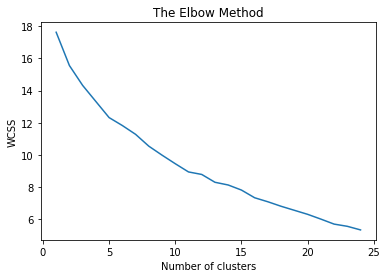

In [223]:
# List for within Cluster Sum of Squares for different cluster. Initially empty list
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 100)
    kmeans.fit(toronto_grouped.drop(columns=['Neighborhood', 'Latitude', 'Longitude']))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

The Elbow Method show WCSS showing decreasing trend even at n_cluster = 25. Since, we do not want to have high number of cluster. For the purpose of applying KMeans, n = 10 will be used.

In [224]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=100)
kmeans.fit(toronto_grouped.drop(columns=['Neighborhood', 'Latitude', 'Longitude']))

# Finding lables for each row
labels = kmeans.labels_

In [225]:
toronto_grouped['Labels'] = labels

In [226]:
toronto_grouped.head()

,Neighborhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Labels
0,Agincourt,43.794200,-79.262029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
1,"Alderwood, Long Branch",43.602414,-79.543484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bayview Village,43.786947,-79.385975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
4,"Bedford Park, Lawrence Manor East",43.733282,-79.419750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1


### Create Map for Toronto

In [227]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [228]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color for clusters
colors = []

for i in range(10):
    col = []
    for j in range(6):
        x = random.choice('ABCDEF0123456789')
        col.append(x)
    col = ''.join(col)
    col = '#' + col
    colors.append(col)

print(colors)
for lat, lon, nhood, cluster in zip(toronto_grouped['Latitude'], toronto_grouped['Longitude'], toronto_grouped['Neighborhood'], toronto_grouped['Labels']):
    label = folium.Popup(str(nhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_toronto)

['#A4931E', '#50825A', '#9B6F22', '#7789D8', '#1B8690', '#29FDDD', '#7344EF', '#726AF7', '#23ED21', '#04D879']


In [229]:
map_toronto

## End of Part 3